In [1]:
import ctypes
from ctypes import c_char_p
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm.notebook import tqdm


In [2]:

def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        # img = Image.open(img_path).convert('L')  # Conversion en gris
        img = Image.open(img_path).convert('RGB')
        img = img.resize((32, 32))  # Resize les images
        img_array = np.array(img, dtype=np.float64).flatten()  # Flatten les vecteurs
        images.append(img_array)
        labels.append(label)
    return images, labels

folder_a = 'data/dataset/resized/gas_giant'
folder_b = 'data/dataset/resized/neptune-like'
folder_c = 'data/dataset/resized/super_earth'

images_a, labels_a = load_images_from_folder(folder_a, [1.0, 0.0, 0.0])
images_b, labels_b = load_images_from_folder(folder_b, [0.0, 1.0, 0.0])
images_c, labels_c = load_images_from_folder(folder_c, [0.0, 0.0, 1.0])

X = np.array(images_a + images_b + images_c)
y = np.array(labels_a + labels_b + labels_c)

# Séparer les données entrainement / test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


print(f"Training data shape: {X_train.shape}")
print(f"Training data shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test data shape: {y_test.shape}")

Training data shape: (1200, 3072)
Training data shape: (1200, 3)
Test data shape: (300, 3072)
Test data shape: (300, 3)


In [3]:
def display_selected_images(images, labels, indices, nrows, ncols):
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        if i < len(indices):
            index = indices[i]
            # image_2d = images[index].reshape((64, 64)) 
            image_3d = images[index].reshape((32, 32, 3)) 
            if image_3d.max() > 1.0:
                image_3d = image_3d / 255.0 
            # ax.imshow(image_2d, cmap='gray')
            ax.imshow(image_3d)
            ax.set_title(f"Label: {labels[index]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

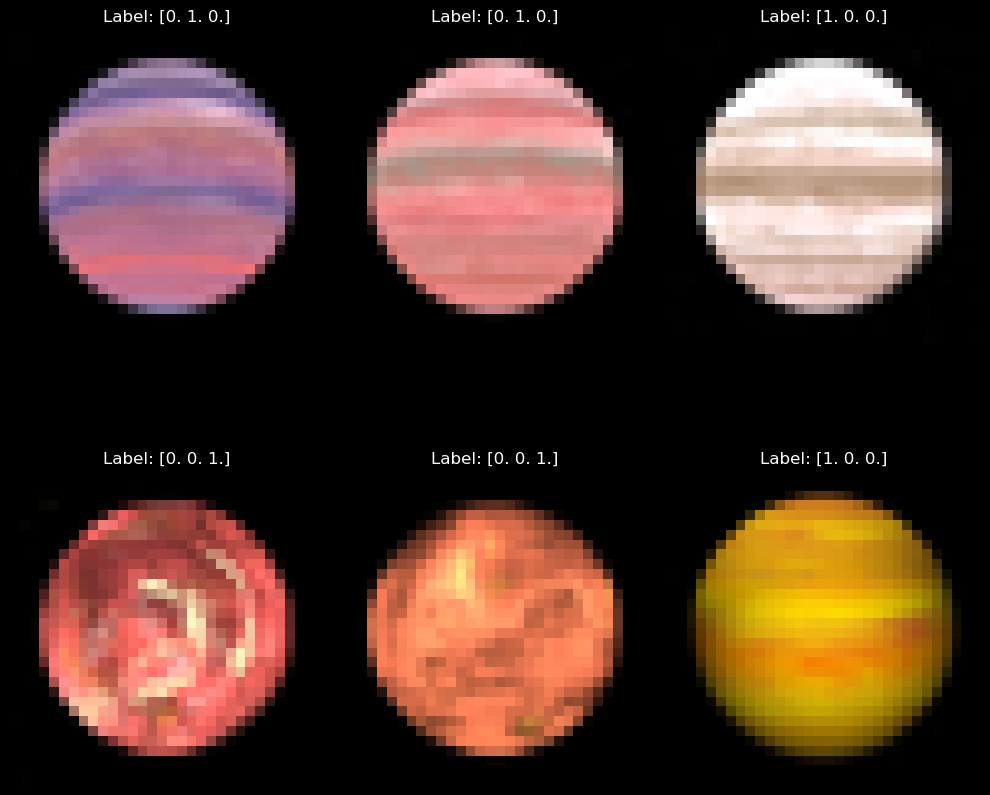

In [4]:
selected_indices = [39, 100, 70, 320, 230, 159]
nrows, ncols = 2, 3

display_selected_images(X_train, y_train, selected_indices, nrows, ncols)

In [5]:
X_train_mean = np.mean(X_train)
X_train_std = np.std(X_train)

print(X_train[5])
print(X_test[:5])

X_train = (X_train - X_train_mean) / X_train_std
X_test = (X_test - X_train_mean) / X_train_std
print("-----------------")
print(X_train[5])
print(X_test[:5])

[0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
-----------------
[-0.90013702 -0.90013702 -0.90013702 ... -0.90013702 -0.90013702
 -0.90013702]
[[-0.90013702 -0.90013702 -0.90013702 ... -0.90013702 -0.90013702
  -0.90013702]
 [-0.90013702 -0.90013702 -0.90013702 ... -0.90013702 -0.90013702
  -0.90013702]
 [-0.90013702 -0.90013702 -0.90013702 ... -0.90013702 -0.90013702
  -0.90013702]
 [-0.90013702 -0.90013702 -0.90013702 ... -0.90013702 -0.90013702
  -0.90013702]
 [-0.90013702 -0.90013702 -0.90013702 ... -0.90013702 -0.90013702
  -0.90013702]]


# Perceptron multi couche

In [6]:
mlp_model = ctypes.CDLL("modele/mlp/target/release/libmlp_classification.so")

# Définir les types d'arguments et de retour des fonctions C
PROGRESS_CALLBACK = ctypes.CFUNCTYPE(None, ctypes.c_int, ctypes.c_double)
mlp_model.mlpInit.argtypes = [ctypes.POINTER(ctypes.c_size_t), ctypes.c_size_t, ctypes.c_double]
mlp_model.mlpInit.restype = ctypes.c_void_p

mlp_model.mlpTrain.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_double),
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_size_t,
    ctypes.c_size_t,
    ctypes.c_size_t,
    ctypes.c_size_t,
    ctypes.c_size_t,
    ctypes.c_bool,
    PROGRESS_CALLBACK,
    ctypes.c_size_t,
]
mlp_model.mlpTrain.restype = None


mlp_model.mlpPredict.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_size_t,
    ctypes.c_bool,
    ctypes.POINTER(ctypes.c_double)
]
mlp_model.mlpPredict.restype = None

mlp_model.mlpFree.argtypes = [ctypes.c_void_p]
mlp_model.mlpFree.restype = None


In [7]:
print(f"vecteur : {X_train}")
print(f"type : {type(X_train[0][0])}")
print(f"pointer : {X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double))}")
print(f"Training data shape: {X_train.shape}")
print(f"Training data shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test data shape: {y_test.shape}")

vecteur : [[-0.90013702 -0.90013702 -0.90013702 ... -0.90013702 -0.90013702
  -0.90013702]
 [-0.90013702 -0.90013702 -0.90013702 ... -0.90013702 -0.90013702
  -0.90013702]
 [-0.90013702 -0.90013702 -0.90013702 ... -0.90013702 -0.90013702
  -0.90013702]
 ...
 [-0.90013702 -0.90013702 -0.90013702 ... -0.90013702 -0.90013702
  -0.90013702]
 [-0.90013702 -0.90013702 -0.90013702 ... -0.90013702 -0.90013702
  -0.90013702]
 [-0.90013702 -0.90013702 -0.90013702 ... -0.90013702 -0.90013702
  -0.90013702]]
type : <class 'numpy.float64'>
pointer : <__main__.LP_c_double object at 0x7fbe8992e550>
Training data shape: (1200, 3072)
Training data shape: (1200, 3)
Test data shape: (300, 3072)
Test data shape: (300, 3)


In [28]:
neurons_size = np.array([X_train.shape[1], 32, 16, 3], dtype=np.uintp)
learning_rate = 0.0001
epochs = 1000
callback_interval = 100

parameter_ptr = neurons_size.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
nn = mlp_model.mlpInit(parameter_ptr, neurons_size.size, learning_rate)

layer : 3
neural matrix : [NeuralMatrix { matrix: [[0.3956608039982772, 0.10072303153468098, -0.4288027986333054, -0.12061262204922896, -0.6883949014943851, -0.10510690397466549, -0.5784353489032545, 0.30124417614673327, 0.8578877625973509, -0.009795600396364179, 0.32156549271038104, -0.5261168392711264, 0.1794362251044248, 0.12464437725664057, -0.7500755466789748, 0.5530956422758138, 0.4810454120947987, -0.23257845212676864, 0.9829054370334886, -0.7054083288079886, -0.40089085362169863, -0.690908866118459, 0.8019863869598813, 0.34399248268914606, 0.4906881075153806, -0.1814222316602052, 0.1176355521170156, -0.5902985963095864, -0.9985923593955746, -0.6645246093300541, -0.4491596438230099, -0.3321073579024012, 0.24258562912228632, 0.760966254326477, -0.042790982009188294, 0.45547130109413425, 0.10598943847380182, -0.7066098592108587, -0.2441737868901095, -0.7415260562651365, 0.5522782466615563, 0.6908413096285861, -0.9802033082470891, 0.6901427920293872, -0.030820442579418295, 0.281438

In [29]:
progress_bar = tqdm(total=epochs, desc="Training Progress")
losses = []
def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)
    losses.append(loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    y_train.shape[1],
    epochs,
    8,
    True,
    callback_func,
    callback_interval  
)
progress_bar.close()

Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

In [30]:
predictions_list_train = []
labels_list_train = []
predictions_list = []
labels_list = []

for k in range(len(X_train)):
    predictions = np.zeros(y_train.shape[1], dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_train[k].size,
        True,
        predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    predictions_list_train.append(predictions)
    labels_list_train.append(y_train[k])

for k in range(len(X_test)):
    predictions = np.zeros(y_train.shape[1], dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_test[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_test[k].size,
        True,
        predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    predictions_list.append(predictions)
    labels_list.append(y_test[k])

In [31]:
predictions_array_train = np.array(predictions_list_train)
labels_array_train = np.array(labels_list_train)

# for i in range(10):
#     print(f"Sample {i}, True Label: {labels_array_train[i]}, Predictions: {predictions_array_train[i]}")

accuracy = np.mean(np.argmax(predictions_array_train, axis=1) == np.argmax(labels_array_train, axis=1))
print(f"Accuracy train data: {accuracy * 100:.2f}%")

Accuracy train data: 34.50%


In [32]:
predictions_array = np.array(predictions_list)
labels_array = np.array(labels_list)

# for i in range(10):
#     print(f"Sample {i}, True Label: {labels_array[i]}, Predictions: {predictions_array[i]}")

accuracy = np.mean(np.argmax(predictions_array, axis=1) == np.argmax(labels_array, axis=1))
print(f"Accuracy test data: {accuracy * 100:.2f}%")

Accuracy test data: 28.67%


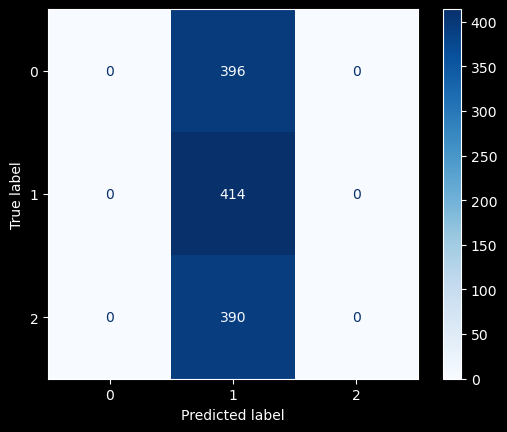

In [33]:
cm = confusion_matrix(np.argmax(labels_array_train, axis=1), np.argmax(predictions_array_train, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

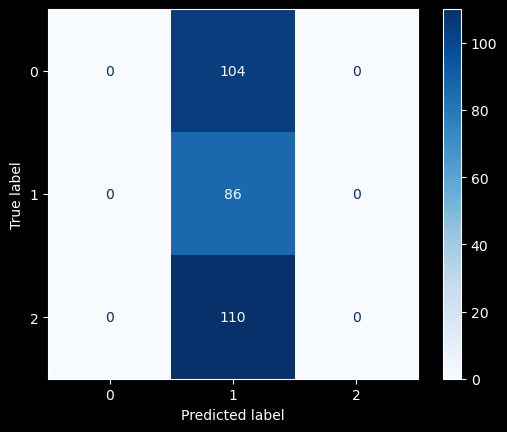

In [34]:

cm = confusion_matrix(np.argmax(labels_array, axis=1), np.argmax(predictions_array, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

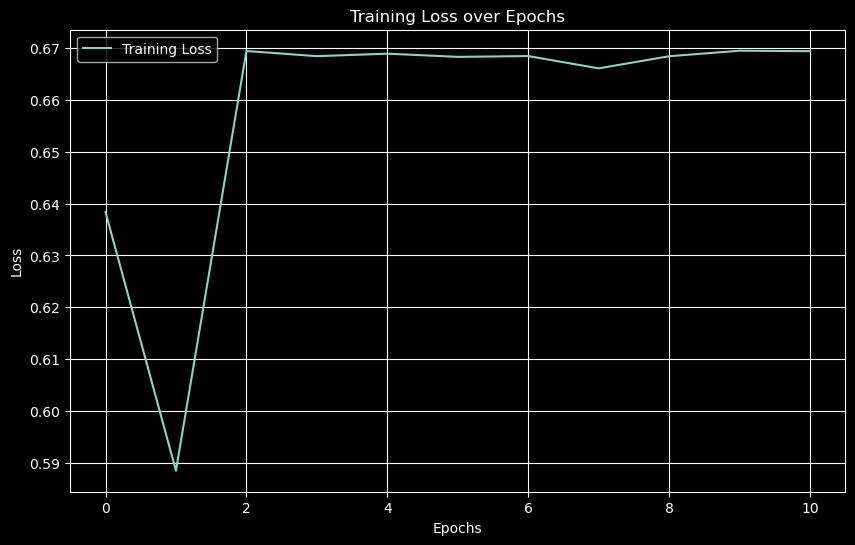

In [35]:
def plot_losses(losses):
    plt.figure(figsize=(10, 6))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(losses)

In [27]:
mlp_model.mlpFree(nn)